## Q-learning (off-policy TD Control) with Replay Buffer

Resources used while writing this notebook:
- [Nimish Sanghi's book on Deep RL](https://www.amazon.com/Deep-Reinforcement-Learning-Python-TensorFlow/dp/1484268083)

- Off-policy learning involves two separate policies: 
    - behavior policy $b(a|s)$ to explore and generate examples; 
    - target policy $\pi(a|s)$ that the agent is trying to learn as the optimal policy.
- Accordingly, we could use the samples generated by the behavior policy again and again to train the agent. The approach makes the process sample efficient as a single transition observed by the agent can be used multiple times. This is called *experience replay*. 
- The agent is collecting experiences from the environment and replaying those experiences multiple times as part of the learning process. In experience replay, we store the samples (s, a, r, s', done) in a buffer.
- The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values. 
- Therefore, we can always use older samples from a behavior policy and apply them again and again.
- We keep the buffer size fixed to some predetermined size and keep deleting the older samples as we collect new ones. 
- The process makes learning sample efficient by reusing a sample multiple time. The rest of the approach remains the same as a Q-learning agent.

In [1]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [2]:
class Q_Learning:
    """Q-learning (off-policy TD control) algorithm."""
    def __init__(self, get_possible_actions, strategy, 
                 epsilon=1, alpha=1, gamma=1):
        self._Q = defaultdict(lambda: defaultdict(lambda: 0))
        self.get_possible_actions = get_possible_actions
        self.epsilon = epsilon
        self.strategy = strategy
        self.alpha = alpha   # learning rate or step size
        self.gamma = gamma   # discount factor


    def _get_Q(self, state, action):
        return self._Q[state][action]


    def set_Q(self, state, action, value):
        self._Q[state][action] = value


    def update(self, state, action, reward, next_state, done):
        """
        This is the main update function for the Q-learning algorithm.
        Note that this function only contains the update equations, 
        not the entire Q-learning algorithm.
        """
        if not done:
            best_next_action = self.max_action(next_state)
            td_error = reward + \
                       self.gamma * self._get_Q(next_state, best_next_action) - \
                       self._get_Q(state, action)
        else:
            td_error = reward - self._get_Q(state, action)
        q_value = self._get_Q(state, action) + self.alpha * td_error
        self.set_Q(state, action, q_value)


    def max_action(self, state):
        """
        Return the best action for a given state, ie,
        the action in the state-action pair that has the highest Q-value.
        If there are multiple actions with the same Q-value,
        return a random action from the set of best actions.
        """
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")
        for action in actions:
            q_value = self._get_Q(state, action)
            if q_value > best_q_value:
                best_action = [action]
                best_q_value = q_value
            elif q_value == best_q_value:
                best_action.append(action)
        return np.random.choice(np.array(best_action))


    def get_action(self, state):
        """
        Choose an action based on the input strategy.
        """
        return self.strategy(self.epsilon, self.get_possible_actions,
                             state, self.max_action)



In [3]:
def epsilon_greedy_strategy(epsilon, get_possible_actions, state, max_action):
    """
    Epsilon-greedy strategy.

    Choose a random number in the interval [0, 1) with a uniform 
    probability distribution. Use np.random.random() to do this.

    If this random number is less than epsilon, return a random action.
    Otherwise, return the best action for the given state.
    """
    actions = get_possible_actions(state)
    if len(actions) == 0:
        return None
    random_number = np.random.random()
    if random_number < epsilon:
        # exploration
        return np.random.choice(actions)
    else:
        # exploitation
        return max_action(state)
    

In [4]:
def fn():
    lst = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    return lst[-10:] + [1]


fn()

[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 1]

In [5]:
class ReplayBuffer:
    def __init__(self, size):
        """
        :param size: maximum number of items in the buffer
        """
        self.size = size
        self.buffer = []  # list to store the items

    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        """
        Add a new item to the buffer.
        If the buffer is full, remove the oldest item.
        """
        item = (state, action, reward, next_state, done)
        self.buffer = self.buffer[-self.size:] + [item]

    def sample(self, batch_size):
        """
        Sample a batch of items from the buffer.
        """
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        state, action, reward, next_state, done_flag = list(zip(*samples))
        return state, action, reward, next_state, done_flag


In [6]:
def train_agent(env, agent, num_episodes=10_000, t_max=10_000, decay_rate=None,
                replay_buffer=None, batch_size=16):
    """
    This is a generic training function.

    env: gymnasium environment
    agent: Q_Learning object
    num_episodes: (int) number of episodes to train the agent
    t_max: (int) maximum number of steps per episode
    decay_rate: (float) epsilon decay rate
    replay_buffer: ReplayBuffer object
    batch_size: (int) batch size for experience replay
    """
    episode_rewards = []
    for i in tqdm(range(num_episodes)):
        G = 0
        state, _ = env.reset()
        for t in range(t_max):
            action = agent.get_action(state)
            next_state, reward, done, trunc, _ = env.step(action)
            flag = (done or trunc)
            if replay_buffer is not None:
                replay_buffer.add(state, action, reward, next_state, flag)
                states, actions, rewards, next_states, done_flags = \
                    replay_buffer(batch_size)
                for i in range(batch_size):
                    agent.update(states[i], actions[i], rewards[i],
                                 next_states[i], done_flags[i])
            else:
                agent.update(state, action, reward, next_state, flag)
            G += reward
            if flag:
                episode_rewards.append(G)
                if decay_rate is not None:
                    agent.epsilon = agent.epsilon * decay_rate
                break
            state = next_state
    return np.array(episode_rewards)


In [7]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


### Trying out Q-learning on Cliff Walking environment

In [8]:
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")

In [9]:
# create Cliff Walking environment
cw_env = gym.make("CliffWalking-v0")

In [10]:
cw_env.reset()

(36, {'prob': 1})

In [11]:
cw_env.action_space.n

4

In [12]:
cw_env.observation_space.n

48

In [78]:
def fn():
    agent = Q_Learning(alpha=0.25, epsilon=0.2, gamma=0.99, 
                   get_possible_actions=lambda s : range(cw_env.action_space.n),
                   strategy=epsilon_greedy_strategy)
    replay_buffer = ReplayBuffer(512)
    batch_size = 16
    state, _ = cw_env.reset()
    action = agent.get_action(state)
    next_state, reward, done, trunc, _ = cw_env.step(action)
    flag = (done or trunc)
    replay_buffer.add(state, action, reward, next_state, flag)
    states, actions, rewards, next_states, done_flags = replay_buffer(batch_size)
    return states, actions, rewards, next_states, done_flags


fn()

TypeError: 'ReplayBuffer' object is not callable

In [13]:
# create a Q Learning agent
agent = Q_Learning(alpha=0.25, epsilon=0.2, gamma=0.99, 
                   get_possible_actions=lambda s : range(cw_env.action_space.n),
                   strategy=epsilon_greedy_strategy)

# train agent using replay buffer and get rewards for episodes
rewards = train_agent(cw_env, agent, num_episodes=5000, 
                      replay_buffer=ReplayBuffer(512), decay_rate=0.99)

  0%|          | 0/5000 [00:00<?, ?it/s]


TypeError: 'ReplayBuffer' object is not callable

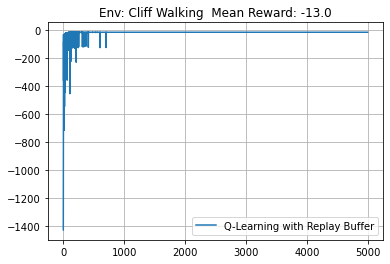

In [38]:
plot_rewards("Cliff Walking", rewards, "Q-Learning with Replay Buffer")

In [39]:
def fn():
    action_dict = {
        0: "UP",
        1: "RIGHT",
        2: "DOWN",
        3: "LEFT"
    }
    state, _ = cw_env.reset()
    print(f"state: {state}")
    while True:
        best_action = agent.max_action(state)
        print(f"best_action: {action_dict[best_action]}")
        next_state, reward, done, trunc, _ = cw_env.step(best_action)
        if done or trunc:
            print(f"Terminal state reached.\nState: {next_state}")
            break
        state = next_state
        print(f"state: {state}")

fn()

state: 36
best_action: UP
state: 24
best_action: RIGHT
state: 25
best_action: RIGHT
state: 26
best_action: RIGHT
state: 27
best_action: RIGHT
state: 28
best_action: RIGHT
state: 29
best_action: RIGHT
state: 30
best_action: RIGHT
state: 31
best_action: RIGHT
state: 32
best_action: RIGHT
state: 33
best_action: RIGHT
state: 34
best_action: RIGHT
state: 35
best_action: DOWN
Terminal state reached.
State: 47


### Trying out Q-learning on Taxi environment

In [ ]:
Image(url="https://gymnasium.farama.org/_images/taxi.gif")

In [ ]:
t_env = gym.make("Taxi-v3")

In [ ]:
t_env.reset()

(208, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

In [ ]:
t_env.action_space.n

6

In [ ]:
t_env.observation_space.n

500

In [ ]:
agent2 = Q_Learning(
    get_possible_actions = lambda state: range(t_env.action_space.n),
    strategy = epsilon_greedy_strategy, 
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_agent(t_env, agent2, num_episodes=5000, decay_rate=0.99)

100%|██████████| 5000/5000 [00:10<00:00, 465.32it/s]


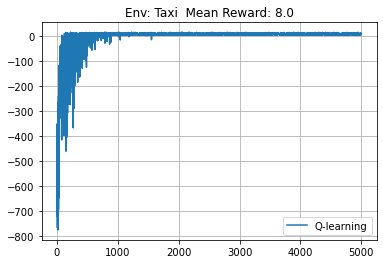

In [ ]:
plot_rewards("Taxi", rewards, "Q-learning")